# Signal Creation Pipeline

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns

from modules.data_utils import load_reddit_data, load_bitcoin_data
from modules.data_cleaning import preprocess_data
from modules.sentiment_analysis import get_roberta_checkpoint

## Load and clean data

In [3]:
df = load_reddit_data()
df_price = load_bitcoin_data()

In [4]:
df = preprocess_data(df)

## Descriptive statistics

### num_comments

Look at how the post activity is done

Text(0.5, 1.0, 'Number of comments distribution')

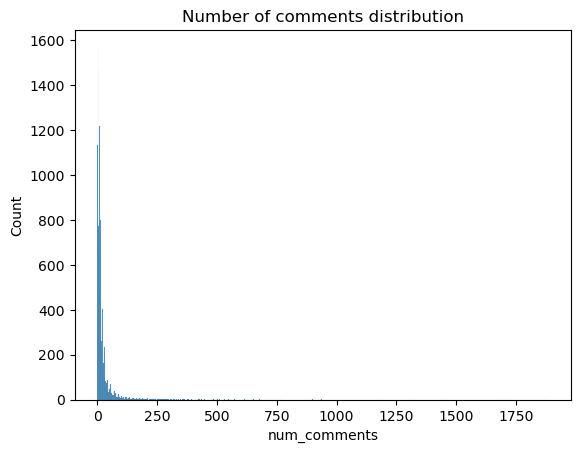

In [19]:
sns.histplot(df, x="num_comments")
plt.title("Number of comments distribution")

We see that most posts are unatractive; we assume that those posts have no influence on the btc price. Let's filter all posts below 100 comments.

<Axes: xlabel='num_comments', ylabel='Count'>

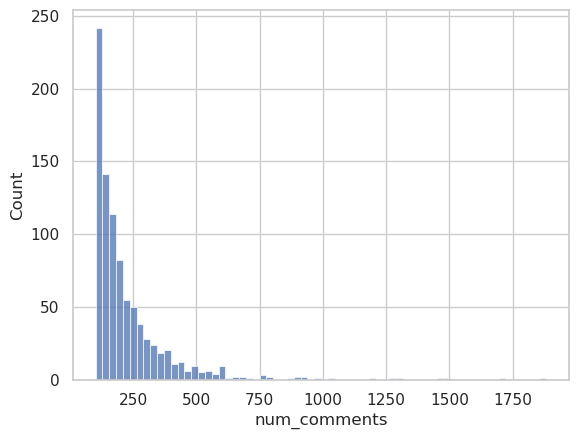

In [5]:
mask = df["num_comments"] > 100
sns.histplot(df[mask], x="num_comments")

### Authors diversity

Let's see if some authors are more influential than others

Text(0.5, 1.0, 'Top 10 authors')

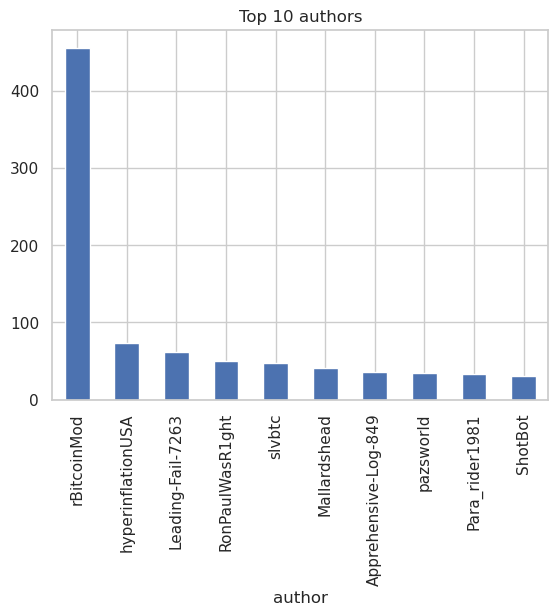

In [6]:
df["author"].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 authors")

We see that the first author is rBitcoinMod. This is a bot and the text it generates is not relevant as we don't have access to the comments. Let's filter him as well

Text(0.5, 1.0, 'Top 10 authors without rBitcoinMod')

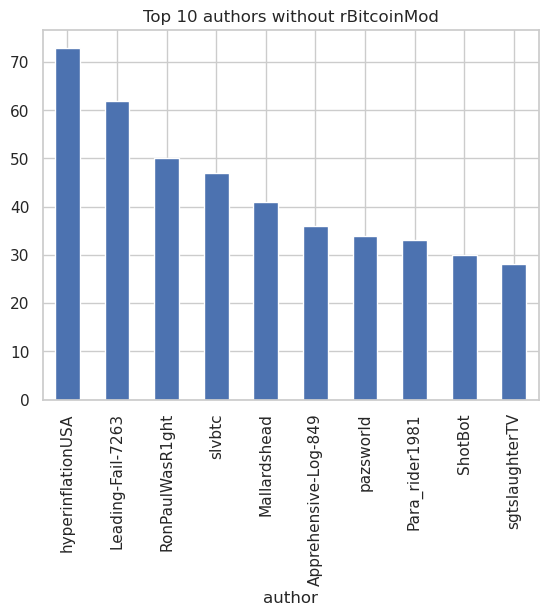

In [7]:
mask = df["author"] != "rBitcoinMod"
df[mask]["author"].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 authors without rBitcoinMod")

([], [])

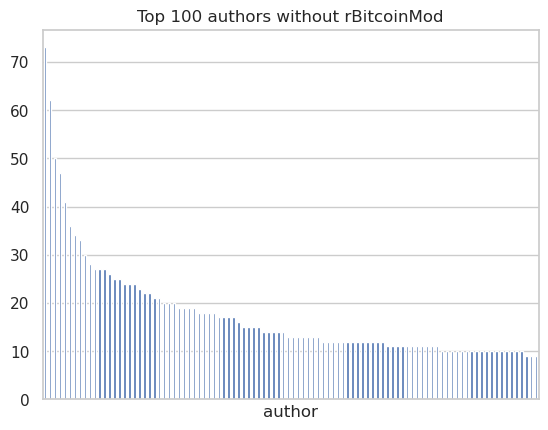

In [8]:
df[mask]["author"].value_counts().head(100).plot(kind='bar')
plt.title("Top 100 authors without rBitcoinMod")
# Remove x-axis ticks
plt.xticks([])

We have some very active authors and then they are more sparse.  

### Text samples

Let's dive at the content of our post

In [15]:
sample_text = df["selftext"].sample(1).values[0]
print(sample_text)

Hi everybody,

I was looking at my peer info in my GUI, all Peers addresses are onion addresses except one which points to my local address.  It looks something like this:

Peers      Address                                             Type               Network

50           \[down arrow\] [127.0.0.1:43724. ](https://127.0.0.1:43724)\[blank\]            Onion

&#x200B;

My hatch is that another user is downloading my copy of the blockchain cause inbound connection. Is that correct? I would just like to know what "50" is doing.

Thanks for your assistance...


### Time participation

See how link to bitcoin the number of comments are

<Axes: xlabel='date'>

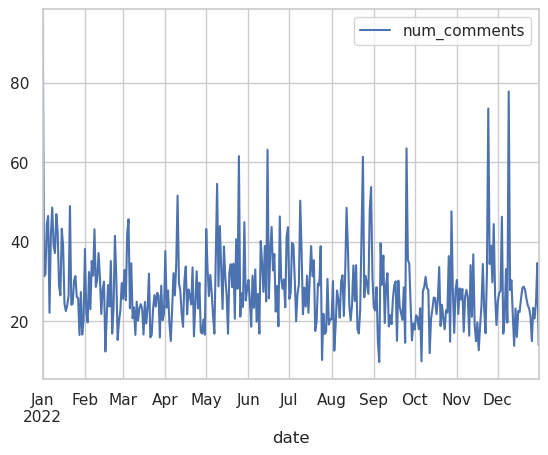

In [23]:
df["date"] = df.index.floor('d')
df_daily = df[["date","num_comments"]].groupby("date").mean()
df_daily.plot(y="num_comments")

<Axes: xlabel='date'>

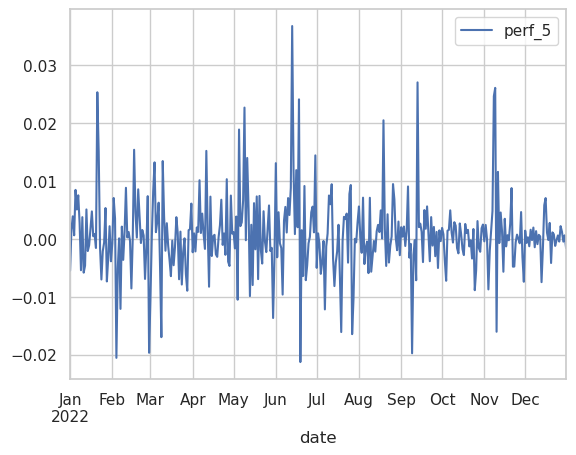

In [28]:
df_price["date"] = pd.to_datetime(df_price["datetime"]).dt.floor('d')
df_price_daily = df_price[["date", "open","perf_5"]].groupby("date").mean()
df_price_daily.plot(y="perf_5")

## Sentiment Analysis

In [ ]:
# df = get_roberta_sentiment(df)

In [5]:
# get checkpoint
sentiment_roberta = get_roberta_checkpoint()

# merge sentiment
df = pd.merge(df, sentiment_roberta, how="left", on="submission")
df = df.set_index("datetime")

## Relevance filtering

In [6]:
# LDA filter
topic_keywords = pd.read_csv("topic_keywords.csv")
trading_keywords = topic_keywords.loc[topic_keywords["Topic"]=="Topic 2", "Keyword"].values

In [7]:
com_filter = (df["num_comments"] > 100)
lda_filter = df["selftext"].str.lower().str.contains("|".join(trading_keywords))

In [8]:
(lda_filter).sum(), (com_filter).sum(), (com_filter & lda_filter).sum()

(11048, 714, 571)

In [20]:
print(df.shape)
df_lda = df.loc[lda_filter].copy() # filter on LDA topics
print(df_lda.shape)

(15582, 30)
(11048, 30)


## Signal

In [16]:
def get_alpha(df: pd.DataFrame, lag: str = "24h"):
    df["rolling_positive_score"] = df["positive_score"].rolling(lag).sum()
    df["rolling_negative_score"] = df["negative_score"].rolling(lag).sum()
    df["alpha"] = (df["rolling_positive_score"] - df["rolling_negative_score"]) / (df["rolling_positive_score"] + df["rolling_negative_score"] + 1e-4)
    return df

In [21]:
df = get_alpha(df)
df_lda = get_alpha(df_lda)

# Price prediction

In [22]:
df_date_col_name = "created"
df_price_date_col_name = "datetime"

df[df_date_col_name] = pd.to_datetime(df[df_date_col_name])
df_lda[df_date_col_name] = pd.to_datetime(df_lda[df_date_col_name])
df_price[df_price_date_col_name] = pd.to_datetime(df_price[df_price_date_col_name])

In [23]:
# Sort df2 by timestamp to ensure binary search can be applied
df = df.sort_values(by='datetime')
df_lda = df_lda.sort_values(by='datetime')
df["datetime"] = df.index
df_lda["datetime"] = df_lda.index

# Method to find the closest timestamp in df2 that is less than or equal to the timestamp in df1
def find_closest_below(row, df):
    # Filter df2 to only include rows where the timestamp is less than or equal to the current row's timestamp in df1
    eligible_signals = df[df['datetime'] <= row['datetime']]
    # If there are no eligible timestamps in df2, return NaN or some default value
    if eligible_signals.empty:
        return pd.NA
    else:
        # Return the signal of the closest timestamp
        return eligible_signals.iloc[-1]['alpha']

# Apply the function to df1
df_price['signal'] = df_price.apply(find_closest_below, df=df, axis=1)
df_price['signal_lda'] = df_price.apply(find_closest_below, df=df_lda, axis=1)

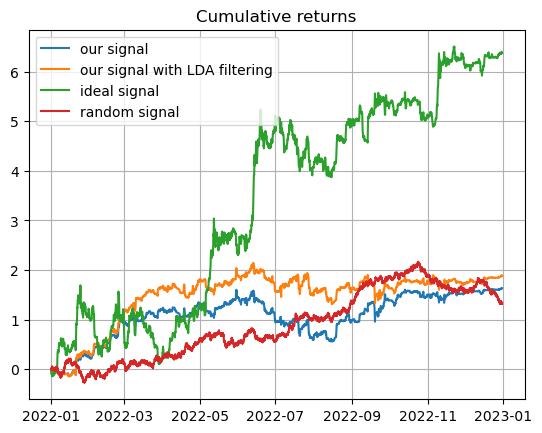

In [55]:
lag = 5
df_price["real"] = df_price[f"perf_{lag}"] * df_price["signal"]
df_price["real_lda"] = df_price[f"perf_{lag}"] * df_price["signal_lda"]

# df_price["random_signal"] = np.random.uniform(low=-1, high=1, size=len(df_price))
df_price["random_signal"] = np.random.normal(0, 0.01, size=len(df_price))

plt.plot(df_price["datetime"], df_price["real"].cumsum(), label="our signal")
plt.plot(df_price["datetime"], df_price["real_lda"].cumsum(), label="our signal with LDA filtering")
plt.plot(df_price["datetime"], df_price[f"perf_{lag}"].cumsum(), label="ideal signal") # TODO: should we square it?
plt.plot(df_price["datetime"], df_price["random_signal"].cumsum(), label="random signal")

plt.title("Cumulative returns")
plt.grid()
plt.legend()

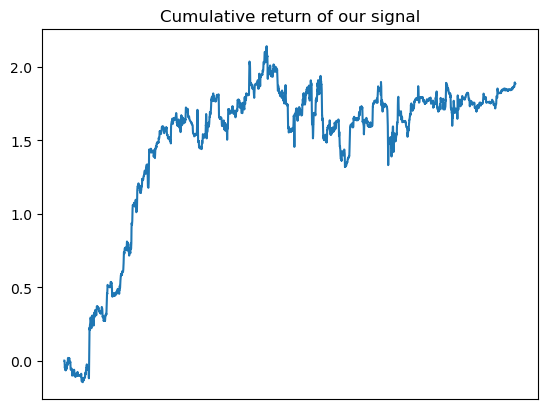

In [139]:
lag = 5
df_price["real"] = df_price[f"perf_{lag}"] * df_price["signal"]


plt.plot(df_price["datetime"],df_price["real"].cumsum())
plt.title("Cumulative return of our signal")
plt.xticks([])
plt.show()

#### Bitcoin vs. Sentiment signal

Text(0.5, 1.0, 'Bitcoin price 2022')

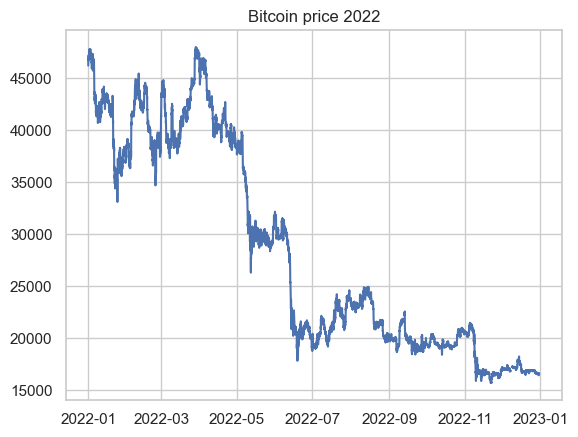

In [41]:
plt.plot(df_price["datetime"], df_price["open"])
plt.title("Bitcoin price 2022")

In [54]:
df.loc[df["author"].str.contains("bot"), "author"].unique()

array(['bot-repost-bot', 'solar_robot', 'Im_not_a_robot_8634', 'botolo',
       'Gregsbot', 'mrrobbottt', 'mulebotte', 'robotvoxy',
       'MonkeySoapRobotz', 'radarbot', 'DCARobot', 'toyrobotics',
       'TheRobotDr', 'therobotnipple'], dtype=object)

In [57]:
df["author"].nunique()

9819

In [47]:
df_price[["signal", "perf_5"]].isna().sum()

signal     1
perf_5    57
dtype: int64

In [49]:
df_price[["signal", "perf_5"]].dropna().corr()

,signal,perf_5
signal,1.000000,0.018753
perf_5,0.018753,1.000000


<Axes: >

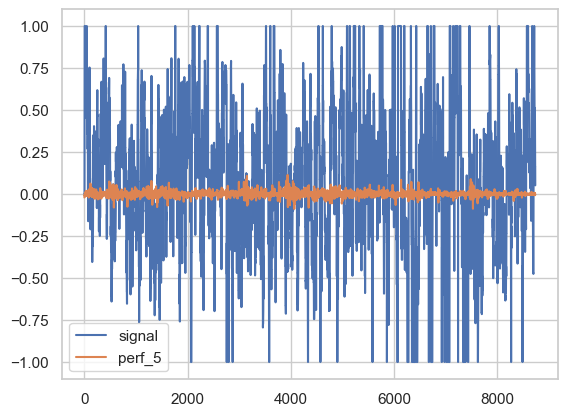

In [52]:
df_price[["signal", "perf_5"]].dropna().plot()

In [106]:
filter = df["selftext"].str.contains("http")
df.loc[filter, "selftext"].sample(1)

11071    [https://www.forbes.com/sites/markkantrowitz/2...
Name: selftext, dtype: object

In [107]:
df["selftext"].str.startswith("http|[http", regex=True).sum() / df.shape[0]

0.0